In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MACCSkeys
import pandas as pd
import numpy as np
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt

Reading the data obtained while running the code `Tox21_preprocessing_I.Rmd` and finding the compounds that have disconnected structures (`.` in the SMILES > these compounds are salts).

In [ ]:
data = pd.read_csv('final_data.tsv', sep='\t')
salts = data[data['SMILES'].str.contains(r'\.')].reset_index(drop=True)

Using the following rules to remove the salts

Total amout of salts: 1600
Removing following groups and normalising the resulting molecules.
Always checking if the resulting ion (after removal) is duplicated. If true, then deduplicating the SMILES.
Removing:
1. Li,Na,K,Ca,Mg,Ba - 1248
2. Cl,Br,I - 508
3. O,N - 408
4. [O-]S(=O)(=O)[O-] - 402 (sulfate)
5. OS(O)(=O)=O - 346 (sulphuric acid)
6. [N+](=O)([O-])[O-] - 343 (nitrate)
7. [N+](=O)(O)[O-] - 337 (nitric acid)
8. [O-]P(=O)([O-])[O-] - 337 (phosphate)
9. C(=O)([O-])[O-] - 336 (carbonate)
10. C(=O)(O)O - 335 (carbonic acid)
11. OP(=O)(O)O - 331 (phosphoric acid)
12. CC(=O)[O-] - 321 (acetate)
13. CC(=O)O - 308 (acetic acid)
14. C1=CC=C(C=C1)C(=O)[O-] - 308 (benzoate)
15. C1=CC=C(C=C1)C(=O)O  - 308 (benzoic acid)
16. C1=CC=C(C(=C1)C(=O)O)O - 308 (salicylic acid)
17. C1=CC=C(C(=C1)C(=O)O)[O-] - 308 (salicylate)
18. C(F)(F)(F)S(=O)(=O)[O-] - 291 (triflate)
19. C(CC(=O)O)C(=O)O - 283 (succinic acid)
20. C(CC(=O)[O-])C(=O)[O-] - 283 (succinate)
21. OC(=O)C(O)C(O)C(=O)O - 265 (2,3-dihydroxysuccinic acid)
22. OO - 264

Removing following compounds:

24. [Na+].[Na+].F[Si--](F)(F)(F)(F)F - 263
25. [NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-] - 262
26. [NH4+].[NH4+].F[Si--](F)(F)(F)(F)F - 261
27. compounds containing following transition metal ions:
* Zn - 255
* Mn - 253
* Co - 252
* Ag - 251
* Cu - 248
* Gd - 246
* Hg - 246 
* Cr - 244
* Be - 244
* Ni - 243
* Fe - 239

28. C(C(=O)O)C(CC(=O)O)(C(=O)O)O - 220 (citric acid)
29. COS(=O)(=O)[O-] - 213 (methylsulfate)
30. CS(=O)(=O)[O-] - 210 (methanesulfonate)
31. CS(=O)(=O)O - 178 (methanesulfonic acid)
32. C(=C/C(=O)O)\C(=O)O - 131 (fumaric acid)
33. C(C(C(=O)O)O)C(=O)O - 129 (malic acid)
34. C(=O)(C(=O)O)O - 125 (oxalic acid)  
35. O=C(O)c1ccccc1O - 123 (salicylic acid)
36. C(CS(=O)(=O)O)O - 122 (isethionic acid)
37. CC(C(=O)O)O - 119 (lactic acid)
38. CCCCCCCCCCCC(=O)O - 118 (lauric acid)
39. CCCCCCCCCCCCCCCCCC(=O)[O-] - 117 (stearate)
40. extra benzoate removal O=C([O-])c1ccccc1 - 115
41. CO - 114

42. Removing F[B-](F)(F)F (this ion alone didn't show toxic effects) - 95
43. For the same reason removing F[P-](F)(F)(F)(F)F - 76
44. And also O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F - 58
45. And tosylate Cc1ccc(S(=O)(=O)[O-])cc1 - 52


46. CCC(=O)O (used as a solvent) - 51 (propionic acid)

47. One by one checking the remaining chemicals based on their ID and structure and if it is impossible to figure out which ion is toxic removing the compound


In [ ]:
for i in range(len(salts)):
    mol = Chem.MolFromSmiles(salts.iloc[i]['SMILES']) 
    remover = SaltRemover(defnData='OCCN(CCO)CCO') # replacing the structure based on the previous list
    try:
        stripped = remover.StripMol(mol)
        new_smiles = Chem.MolToSmiles(stripped)
        
        if '.' in new_smiles:
            first = new_smiles.split('.')[0]
            second = new_smiles.split('.')[1]
            if first == second and len(new_smiles.split('.')) == 2:
                print(first, second)
                salts.at[i,'SMILES'] = first
            else:
                salts.at[i,'SMILES'] = new_smiles
        else:
            salts.at[i,'SMILES'] = new_smiles
    except:
        print(salts.iloc[i]['SMILES'])

In [ ]:
for i in range(len(salts)):
    if '.' in salts.iloc[i]['SMILES']:
        print(salts.iloc[i]['SMILES'])
        
        salts.at[i,'SMILES'] = ''

In [ ]:
remaining_salts = salts[salts['SMILES'].str.contains(r'\.')]
print(len(remaining_salts)) # After cleaning it should be 0
#remaining_salts.to_csv('remaining_salts.tsv', sep='\t', index=False) # After cleaning the file should be empty

In [ ]:
# Checking the remaining structures during cleaning process
mols = [Chem.MolFromSmiles(smi) for smi in remaining_salts.SMILES]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(700, 700))

In [ ]:
salts_original = data[data['SMILES'].str.contains(r'\.')].reset_index(drop=True)
salts_original.insert(1, 'SMILES_new', salts['SMILES'])
salts_original.to_csv('salts_checkup.tsv', sep='\t', index=False)
new_smiles = salts_original[['SMILES_new', 'ID']]
data_new = new_smiles.merge(data, left_on='ID', right_on='ID', how='outer')
data_new = data_new[data_new['SMILES_new'] != ''].reset_index(drop=True)

duplicates = data_new[data_new.SMILES_new.duplicated(keep=False)].sort_values('SMILES_new')
not_dup = duplicates[duplicates['SMILES_new'].isnull()].reset_index(drop=True)
not_dup2 = data_new[-data_new.SMILES_new.duplicated(keep=False)].sort_values('SMILES_new').reset_index(drop=True)
unique = pd.concat([not_dup, not_dup2], axis=0).reset_index(drop=True)
duplicates = duplicates[-duplicates['SMILES_new'].isnull()].reset_index(drop=True)
unique_duplicates = duplicates.drop_duplicates(['SMILES_new'], keep='first').reset_index(drop=True)

In [ ]:
for i in range(len(unique_duplicates)):
    smiles = unique_duplicates.iloc[i]['SMILES_new']
    dup2summary = duplicates[duplicates['SMILES_new'] == smiles]
    for j in range(3,15):
        new_val = np.max(dup2summary.iloc[:,j])   
        unique_duplicates.iloc[i,j] = new_val

In [ ]:
final_unique = pd.concat([unique, unique_duplicates], axis=0).reset_index(drop=True)
final_unique['SMILES_new'] = np.where(final_unique['SMILES_new'].isnull(), final_unique['SMILES'], final_unique['SMILES_new'])

Removing the compounds that are still not suitable:
* [As]#[In]
* O1[As]2O[As]3O[As]1O[As](O2)O3
* [Cu]I
* Br[Ca]Br
* [Na]I
* Cl[Ba]Cl
* Sr2+
* Ti
* V
* O=[Cr]O[Cr]=O
* CCCCN(CCCC)C(=S)S[Ni]SC(=S)N(CCCC)CCCC
* Cl[Ni]Cl
* Cl[Zn]Cl
* [O-][N+]1=CC=CC=C1S[Zn]SC2=CC=CC=[N+]2[O-]
* Cl[Yb](Cl)Cl
* Cl[Zr](Cl)(C1C=CC=C1)C2=CC=CC2
* O=[Zr](Cl)Cl
* O=[Mo](=O)=O
* Cl[Pd]Cl
* [O-][N+](=O)O[Cd]O[N+]([O-])=O
* O=[Cd]
* [Cd+2]
* [Cl-][Pt]1([Cl-])NCCN1
* [H][C@@]12CCCC[C@@]1([H])N[Pt]3(N2)OC(=O)C(=O)O3
* N[Pt](N)(Cl)Cl
* N[Pt]1(N)OC(=O)C2(CCC2)C(=O)O1
* CCP(CC)(CC)=[Au]S[C@H]1O[C@@H](COC(C)=O)[C@H](OC(C)=O)[C@@H](OC(C)=O)[C@@H]1OC(C)=O
* Cl[Au](Cl)Cl
* OC[C@H]1OC(S[Au])[C@H](O)[C@@H](O)[C@@H]1O
* N#C[Au-]C#N
* O=C([O-])CC(S[Au])C(=O)[O-]
* Cl[Nd](Cl)Cl
* Cl[Dy](Cl)Cl
* FB(F)F
* CC(=O)O[Al](O)O
* CCCCCCCCCCCCCCCCCC(=O)O[Al](O)O
* CCCCO[Al](OCCCC)OCCCC
* CCOC(=O)\C=C(\C)O[Al](OC(C)CC)OC(C)CC
* NC(=O)NC1N=C(NC1=O)O[Al](O)O
* O=CO[Al](OC=O)OC=O
* CC(=O)O[Al](O)OC(C)=O
* Cl[In](Cl)Cl
* P#[In]
* Cl[In](Cl)Cl
* O=[Si]=O
* CC[Ge](Cl)(CC)CC
* CC[Sn](Br)(CC)CC
* CCC(C)(CCC(C)C)C(=O)O[Sn](C)(C)OC(=O)C(C)(CC)CCC(C)C
* CCCC[Sn](CCCC)(CCCC)CCCC
* CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC
* CCCC[Sn](CCCC)(CCCC)OC(=O)C(C)=C
* CCCC[Sn](CCCC)(CCCC)OC(=O)C=C
* CCCC[Sn](CCCC)(CCCC)OC(=O)C1=CC=CC=C1
* CCCC[Sn](CCCC)(OC(C)=O)OC(C)=O
* CCCCCCCC[Sn](Cl)(Cl)CCCCCCCC
* Cl[Sn](Cl)(Cl)Cl
* F[Sn](C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3
* O[Sn](C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3
* C[Sn](C)(Cl)Cl
* C[Sn](Cl)(Cl)Cl
* CCCC[Sn](Cl)(CCCC)CCCC
* CCCC[Sn](Cl)(Cl)CCCC
* CCCC[Sn](Cl)(Cl)Cl
* CCCCCCCCCCCC(=O)O[Sn](CCCC)(CCCC)OC(=O)CCCCCCCCCCC
* [SnH2+2]
* [PbH2+2]
* Cl[Sb](Cl)Cl
* O=C([O-])C1O[Sb]2OC(=O)C(O2)C(C(=O)[O-])O[Sb]2OC(=O)C1O2
* [Sb+3]
* C1=CC=C(C=C1)[Bi](C2=CC=CC=C2)C3=CC=CC=C3
* Cl[Bi](Cl)(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3
* Cl[Bi]=O
* O=[Se]=O
* O[Se](O)=O
* O=[Se]([O-])[O-]
* [H+]
* [O-][Cl+][O-]
* [O-][Cl+2]([O-])[O-]
* [O-][Cl+3]([O-])([O-])[O-]
* [O-][Br+2]([O-])[O-]
* II
* OS(O)(=O)=O
* NO
* O=N[O-]
* Tl
* [NH3+]O
* [N-]=[N+]=[N-]
* NN
* OP(O)(O)=O
* OB(O)O
* S=C=S
* OS(F)(=O)=O
* ClS(Cl)(=O)=O
* ClP(Cl)(Cl)=O
* ClP(Cl)(Cl)(Cl)Cl

In [ ]:
for i in range(len(final_unique)):
    if 'ClP(Cl)(Cl)(Cl)Cl' == final_unique.iloc[i]['SMILES_new']:
        print(final_unique.iloc[i]['SMILES_new'])
        
        final_unique.at[i,'SMILES_new'] = ''

In [ ]:
final_unique = final_unique[final_unique['SMILES_new'] != ''].reset_index(drop=True)
#final_unique.to_csv('final_unique.tsv', sep='\t', index=False)

After removing non-toxic ions (i.e. leaving only one part/ion of/from the salt) and compounds that are not suitable for the final application (not suitable for LC/HRMS analysis), it is necessary to neutralise the remaining compounds (https://www.rdkit.org/docs/Cookbook.html).

In [ ]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In [ ]:
mols = [Chem.MolFromSmiles(m) for m in final_unique['SMILES_new']]
list2 = []
for mol in mols:
    neutralize_atoms(mol)
    new_smiles = Chem.MolToSmiles(mol)
    list2.append(new_smiles)
final_unique.insert(1, 'SMILES_final', list2)
#final_unique.to_csv('final_unique_standard.tsv', sep='\t', index=False)

Checking if there are duplicates in the dataset and using the same rules as in `Tox21_preprocessing_I.Rmd` to combine them.

In [ ]:
duplicates2 = final_unique[final_unique.SMILES_final.duplicated(keep=False)].sort_values('SMILES_final')
unique2 = final_unique[-final_unique.SMILES_final.duplicated(keep=False)].sort_values('SMILES_final').reset_index(drop=True)
unique_duplicates2 = duplicates2.drop_duplicates(['SMILES_final'], keep='first').reset_index(drop=True)

for i in range(len(unique_duplicates2)):
    smiles = unique_duplicates2.iloc[i]['SMILES_final']
    dup2summary = duplicates2[duplicates2['SMILES_final'] == smiles]
    for j in range(4,16):
        new_val = np.max(dup2summary.iloc[:,j])   
        unique_duplicates2.iloc[i,j] = new_val
        
final_data = pd.concat([unique2, unique_duplicates2], axis=0).reset_index(drop=True)
#final_data.to_csv('final_data_raw.tsv', sep='\t', index=False)
final_data = final_data.drop(['SMILES_new', 'SMILES', 'ID'], axis=1)
final_data = final_data.rename(columns={'SMILES_final': 'SMILES'})
#final_data.to_csv('final_data_ready.tsv', sep='\t', index=False)

Visualising the data that is ready for selecting the compounds that have the mass spectra in databases and are suitable for calculating the fingerprints.

In [ ]:
final_data.loc[:, final_data.columns != 'SMILES'] = final_data.loc[:, final_data.columns != 'SMILES'].astype('Int64')
final_data = final_data.replace(-9223372036854775808, np.nan)
summary_stat_input = final_data.loc[:, final_data.columns != 'SMILES'].apply(pd.value_counts, dropna=False)
#summary_stat_input.to_csv('summary_stat_input.tsv', sep='\t', index=True)

In [4]:
summary_stat_input = pd.read_csv('summary_stat_input.tsv', sep='\t')
summary_stat_input

,nr.ahr,nr.ar.lbd,nr.ar,nr.aromatase,nr.er.lbd,nr.er,nr.ppar.gamma,sr.are,sr.atad5,sr.hse,sr.mmp,sr.p53
0.0,5503,6236,6619,5266,6319,5153,5996,4700,6504,5852,4665,6082
NaN,1226,1016,558,1936,831,1550,1317,1892,726,1291,1933,999
1.0,754,231,306,281,333,780,170,891,253,340,885,402


<Axes: >

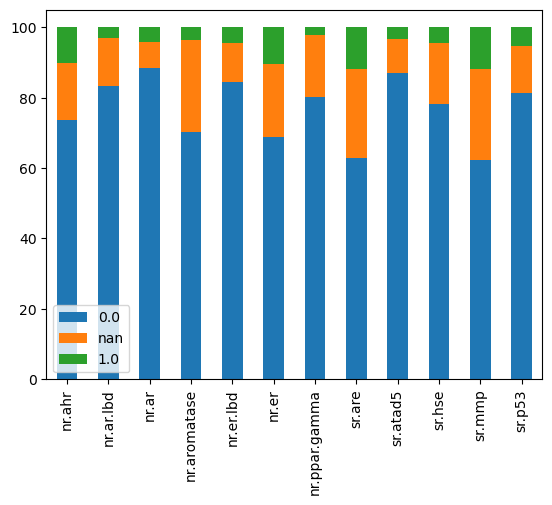

In [5]:
summary_stat_input_T = summary_stat_input.transpose()
stacked_data = summary_stat_input_T.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True)